In [1]:
import numpy as np
from scipy.signal import hilbert, butter, filtfilt, lfilter

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split

import matplotlib.pyplot as plt


Нейронная сеть без нелинейностей

In [36]:
torch.manual_seed(42)
np.random.seed(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Параметры
Fs = 512
T = 1000 
N_EMG = 8
N_joints = 1

# Временной вектор
t = np.linspace(0, T, int(Fs * T))

# Функция для создания фильтра
def butter_filter(order, cutoff, btype, fs):
    nyquist = fs / 2
    normalized_cutoff = np.array(cutoff) / nyquist
    b, a = butter(order, normalized_cutoff, btype=btype)
    return b, a

# Генерация сырых данных ЭМГ
b_myo, a_myo = butter_filter(order=5, cutoff=[15, 150], btype='band', fs=Fs)
b_vel, a_vel = butter_filter(order=1, cutoff=2, btype='low', fs=Fs)
b_hp, a_hp = butter_filter(order=3, cutoff=0.1, btype='high', fs=Fs)

s = lfilter(b_myo, a_myo, np.random.randn(N_EMG, len(t)))

input_signal = torch.tensor(s.copy())
# Создание пространственной матрицы смешивания
A = np.random.randn(N_joints, N_EMG)
target_signal = torch.abs(torch.matmul(torch.tensor(A.copy()), input_signal))
target_signal = torch.tensor(lfilter(b_vel, a_vel, target_signal, axis=1))
target_signal = torch.tensor(lfilter(b_hp, a_hp, target_signal, axis=1))

# Разделение данных на обучающую и валидационную выборки
train_ratio = 0.8
train_size = int(input_signal.shape[1] * train_ratio)
val_size = input_signal.shape[1] - train_size

train_input = input_signal[:, :train_size]
train_target = target_signal[:, :train_size]
val_input = input_signal[:, train_size:]
val_target = target_signal[:, train_size:]

train_input.shape, train_target.shape, val_input.shape, val_target.shape   

# Разбиение на окна
window_size = 512

def create_windows(signal, target, window_size):
    x, y = [], []
    for i in range(0, signal.shape[1] - window_size + 1, window_size):
        x.append(signal[:, i:i+window_size])
        y.append(target[:, i:i+window_size])
    return torch.stack(x), torch.stack(y)

train_x, train_y = create_windows(train_input, train_target, window_size)
val_x, val_y = create_windows(val_input, val_target, window_size)

train_x.shape, train_y.shape, val_x.shape, val_y.shape  

class EMGDataset(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __len__(self):
        return self.x.shape[0]

    def __getitem__(self, idx):
        return self.x[idx].to(torch.float32), self.y[idx].to(torch.float32)

train_dataset = EMGDataset(train_x, train_y)
val_dataset = EMGDataset(val_x, val_y)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)


class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, downsample=None):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size, stride=stride, 
                               padding=(kernel_size - 1) // 2, bias=False)
        self.bn1 = nn.BatchNorm1d(out_channels)
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size, stride=1,
                               padding=(kernel_size - 1) // 2, bias=False)
        self.bn2 = nn.BatchNorm1d(out_channels)
        self.downsample = downsample

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity

        return out

class SimpleNN(nn.Module):
    def __init__(self, kernel_size=3, num_blocks=25, block_expansion=1):
        super(SimpleNN, self).__init__()

        self.weight = nn.Parameter(torch.randn(N_joints, N_EMG), requires_grad=True)

        self.conv1 = nn.Conv1d(1, block_expansion, kernel_size, padding=1, bias=False)
        self.bn1 = nn.BatchNorm1d(block_expansion)

        # Создаем и объединяем остаточные блоки
        self.res_layers = self._make_layer(ResidualBlock, block_expansion, num_blocks, kernel_size)

        self.conv = nn.Conv1d(block_expansion, 1, kernel_size, padding=1, bias=False)
        self.bn = nn.BatchNorm1d(1)

    def _make_layer(self, block, out_channels, num_blocks, kernel_size):
        layers = []
        in_channels = out_channels
        for _ in range(num_blocks):
            layers.append(block(in_channels, out_channels, kernel_size))
        return nn.Sequential(*layers)

    def forward(self, x):
        # x.shape: [batch_size(64), N_EMG(8), window_size(256)]
        x = torch.abs(torch.matmul(self.weight, x))

        x = self.conv1(x)
        x = self.bn1(x)

        x = self.res_layers(x)

        x = self.conv(x)
        x = self.bn(x)

        return x
    
# Гиперпараметры
epochs = 1_500
learning_rate = 0.001

model = SimpleNN().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.9)
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=100, verbose=True, min_lr=1e-6)

def train():
    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        for inputs, targets in train_loader:
            inputs = inputs.to(device)
            targets = targets.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        train_loss /= len(train_loader)

        # Валидация
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs = inputs.to(device)
                targets = targets.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, targets)
                val_loss += loss.item()

        val_loss /= len(val_loader)

        # Обновление шедулера
        scheduler.step()
        # scheduler.step(val_loss)

        # Логирование
        if epoch % 100 == 0:
            current_lr = scheduler.get_last_lr()[0]
            # current_lr = optimizer.param_groups[0]['lr']
            print(f"Epoch {epoch}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, LR: {current_lr:.6f}")

train()


Epoch 0/1500, Train Loss: 1.0091, Val Loss: 0.0599, LR: 0.001000
Epoch 100/1500, Train Loss: 0.0184, Val Loss: 0.0185, LR: 0.000900
Epoch 200/1500, Train Loss: 0.0060, Val Loss: 0.0053, LR: 0.000810
Epoch 300/1500, Train Loss: 0.0053, Val Loss: 0.0045, LR: 0.000729
Epoch 400/1500, Train Loss: 0.0052, Val Loss: 0.0043, LR: 0.000656
Epoch 500/1500, Train Loss: 0.0052, Val Loss: 0.0043, LR: 0.000590
Epoch 600/1500, Train Loss: 0.0051, Val Loss: 0.0043, LR: 0.000531
Epoch 700/1500, Train Loss: 0.0050, Val Loss: 0.0042, LR: 0.000478
Epoch 800/1500, Train Loss: 0.0050, Val Loss: 0.0042, LR: 0.000430
Epoch 900/1500, Train Loss: 0.0059, Val Loss: 0.0042, LR: 0.000387
Epoch 1000/1500, Train Loss: 0.0050, Val Loss: 0.0042, LR: 0.000349
Epoch 1100/1500, Train Loss: 0.0050, Val Loss: 0.0042, LR: 0.000314
Epoch 1200/1500, Train Loss: 0.0050, Val Loss: 0.0041, LR: 0.000282
Epoch 1300/1500, Train Loss: 0.0049, Val Loss: 0.0041, LR: 0.000254
Epoch 1400/1500, Train Loss: 0.0050, Val Loss: 0.0041, LR: 0

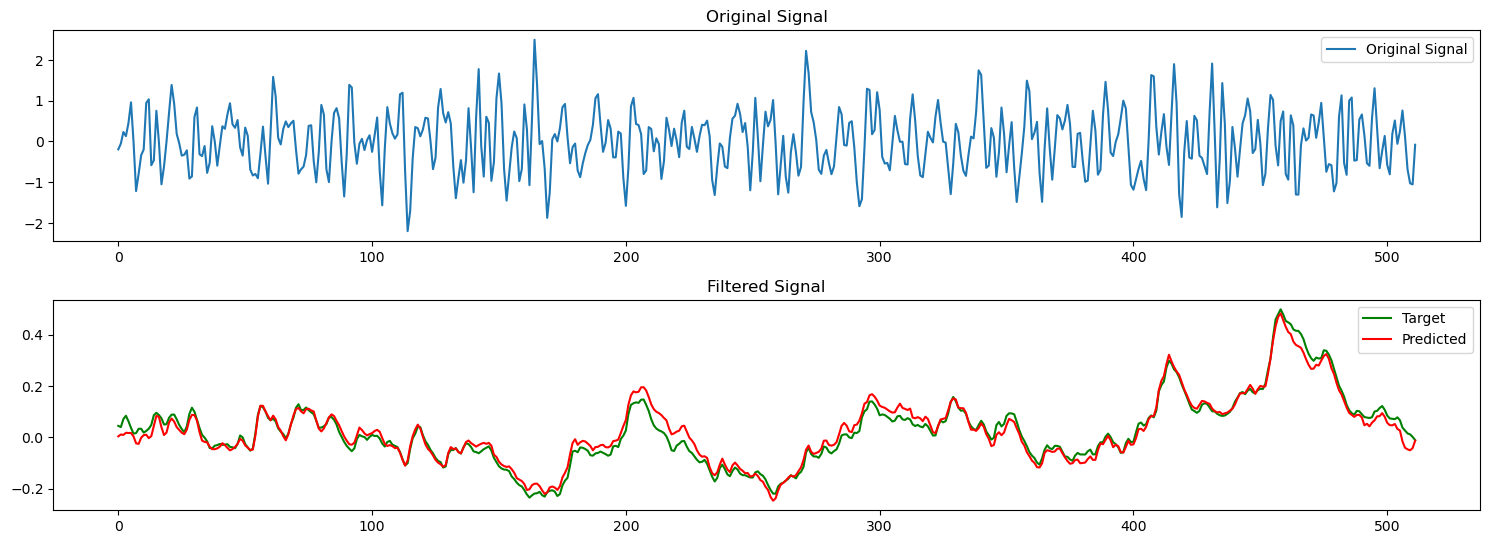

In [38]:
input_signal, target = next(iter(val_loader))

model_output = model(input_signal.to(device)).detach().cpu()

# Визуализация
i = 24
plt.figure(figsize=(15, 8))
plt.subplot(3, 1, 1)
plt.plot(range(len(input_signal[1][0])), input_signal[i][0], label='Original Signal')
plt.title('Original Signal')
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(range(len(target[1][0])), target[i][0], label='Target', color='green')
plt.title('Filtered Signal (Butterworth)')
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(range(len(model_output[1][0])), model_output[i][0], label='Predicted', color='red')
plt.title('Filtered Signal')
plt.legend()

plt.tight_layout()
plt.show()



In [39]:
def corr_coef(true_signal, predicted_signal):

    # Убираем размерность 1
    true_signal = true_signal.squeeze()
    predicted_signal = predicted_signal.squeeze()

    # Вычисляем средние значения
    mean_true = true_signal.mean()
    mean_predicted = predicted_signal.mean()

    # Считаем отклонения от среднего
    deviation_true = true_signal - mean_true
    deviation_predicted = predicted_signal - mean_predicted

    # Вычисляем числитель и знаменатель формулы для корреляции
    numerator = (deviation_true * deviation_predicted).sum()
    denominator = torch.sqrt((deviation_true ** 2).sum() * (deviation_predicted ** 2).sum())

    # Вычисляем коэффициент корреляции
    correlation = numerator / denominator
    return correlation

max_corr = 0
for i in range(64):
    corr = corr_coef(target[i], model_output[i])
    if corr > max_corr:
        max_corr = corr
        best_i = i

max_corr, best_i


(tensor(0.9811), 24)

Нейронная сеть с нелинейностями

In [31]:
torch.manual_seed(42)
np.random.seed(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Параметры
Fs = 512
T = 1000 
N_EMG = 8
N_joints = 1

# Временной вектор
t = np.linspace(0, T, int(Fs * T))

# Функция для создания фильтра
def butter_filter(order, cutoff, btype, fs):
    nyquist = fs / 2
    normalized_cutoff = np.array(cutoff) / nyquist
    b, a = butter(order, normalized_cutoff, btype=btype)
    return b, a

# Генерация сырых данных ЭМГ
b_myo, a_myo = butter_filter(order=5, cutoff=[15, 150], btype='band', fs=Fs)
b_vel, a_vel = butter_filter(order=1, cutoff=2, btype='low', fs=Fs)
b_hp, a_hp = butter_filter(order=3, cutoff=0.1, btype='high', fs=Fs)

s = lfilter(b_myo, a_myo, np.random.randn(N_EMG, len(t)))

input_signal = torch.tensor(s.copy())
# Создание пространственной матрицы смешивания
A = np.random.randn(N_joints, N_EMG)
target_signal = torch.abs(torch.matmul(torch.tensor(A.copy()), input_signal))
target_signal = torch.tensor(lfilter(b_vel, a_vel, target_signal, axis=1))
target_signal = torch.tensor(lfilter(b_hp, a_hp, target_signal, axis=1))

# Разделение данных на обучающую и валидационную выборки
train_ratio = 0.8
train_size = int(input_signal.shape[1] * train_ratio)
val_size = input_signal.shape[1] - train_size

train_input = input_signal[:, :train_size]
train_target = target_signal[:, :train_size]
val_input = input_signal[:, train_size:]
val_target = target_signal[:, train_size:]

train_input.shape, train_target.shape, val_input.shape, val_target.shape   

# Разбиение на окна
window_size = 512

def create_windows(signal, target, window_size):
    x, y = [], []
    for i in range(0, signal.shape[1] - window_size + 1, window_size):
        x.append(signal[:, i:i+window_size])
        y.append(target[:, i:i+window_size])
    return torch.stack(x), torch.stack(y)

train_x, train_y = create_windows(train_input, train_target, window_size)
val_x, val_y = create_windows(val_input, val_target, window_size)

train_x.shape, train_y.shape, val_x.shape, val_y.shape  

class EMGDataset(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __len__(self):
        return self.x.shape[0]

    def __getitem__(self, idx):
        return self.x[idx].to(torch.float32), self.y[idx].to(torch.float32)

train_dataset = EMGDataset(train_x, train_y)
val_dataset = EMGDataset(val_x, val_y)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

# class ConvBlock(nn.Module):
#     def __init__(self, in_channels, out_channels, kernel_size=3, padding=1):
#         super(ConvBlock, self).__init__()
#         self.conv = nn.Conv1d(in_channels, out_channels, kernel_size, padding=padding, bias=False)
#         self.bn = nn.BatchNorm1d(out_channels)
#         self.relu = nn.ELU()

#     def forward(self, x):
#         out = self.conv(x)
#         out = self.bn(out)
#         out = self.relu(out)
#         return out + x  

# class SimpleNN(nn.Module):
#     def __init__(self, kernel_size=3, num_layers=20):
#         super(SimpleNN, self).__init__()
        
#         self.weight = nn.Parameter(torch.randn(N_joints, N_EMG), requires_grad=True)

#         self.conv = nn.Conv1d(1, 1, kernel_size, padding=1, bias=False)
#         self.bn = nn.BatchNorm1d(1)

#         # Создаем и объединяем блоки
#         self.layers = nn.ModuleList([ConvBlock(1, 1, kernel_size) for _ in range(num_layers)])

#         # Полносвязный слой (закомментирован, т.к. не используется)
#         # self.fc = nn.Linear(256, 256, bias=True)

#     def forward(self, x):
#         # x.shape: [batch_size(64), N_EMG(8), window_size(256)]
#         x = torch.abs(torch.matmul(self.weight, x))

#         # Последовательное применение блоков
#         for layer in self.layers:
#             x = layer(x)
#         x = self.conv(x)
#         x = self.bn(x)

#         # Закомментированные строки для развертывания и скучивания обратно
#         # x = x.view(x.size(0), -1)
#         # x = self.fc(x)
#         # x = x.view(-1, 1, 256)

#         return x

class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, padding=1):
        super(ConvBlock, self).__init__()
        self.conv = nn.Conv1d(in_channels, out_channels, kernel_size, padding=padding, bias=False)
        self.bn = nn.BatchNorm1d(out_channels)
        self.relu = nn.ELU()

    def forward(self, x):
        out = self.conv(x)
        out = self.bn(out)
        out = self.relu(out)
        return out

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, downsample=None):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size, stride=stride, 
                               padding=(kernel_size - 1) // 2, bias=False)
        self.bn1 = nn.BatchNorm1d(out_channels)
        self.elu = nn.ELU()
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size, stride=1,
                               padding=(kernel_size - 1) // 2, bias=False)
        self.bn2 = nn.BatchNorm1d(out_channels)
        self.downsample = downsample

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.elu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.elu(out)

        return out

class SimpleNN(nn.Module):
    def __init__(self, kernel_size=3, num_blocks=25, block_expansion=1):
        super(SimpleNN, self).__init__()

        self.weight = nn.Parameter(torch.randn(N_joints, N_EMG), requires_grad=True)

        self.conv1 = nn.Conv1d(1, block_expansion, kernel_size, padding=1, bias=False)
        self.bn1 = nn.BatchNorm1d(block_expansion)
        self.elu = nn.ELU()

        # Создаем и объединяем остаточные блоки
        self.res_layers = self._make_layer(ResidualBlock, block_expansion, num_blocks, kernel_size)

        self.conv = nn.Conv1d(block_expansion, 1, kernel_size, padding=1, bias=False)
        self.bn = nn.BatchNorm1d(1)

    def _make_layer(self, block, out_channels, num_blocks, kernel_size):
        layers = []
        in_channels = out_channels
        for _ in range(num_blocks):
            layers.append(block(in_channels, out_channels, kernel_size))
        return nn.Sequential(*layers)

    def forward(self, x):
        # x.shape: [batch_size(64), N_EMG(8), window_size(256)]
        x = torch.abs(torch.matmul(self.weight, x))

        x = self.conv1(x)
        x = self.bn1(x)
        x = self.elu(x)

        x = self.res_layers(x)

        x = self.conv(x)
        x = self.bn(x)

        return x
    
# Гиперпараметры
epochs = 1_500
learning_rate = 0.001

model = SimpleNN().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.9)
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=100, verbose=True, min_lr=1e-6)

def train():
    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        for inputs, targets in train_loader:
            inputs = inputs.to(device)
            targets = targets.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        train_loss /= len(train_loader)

        # Валидация
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs = inputs.to(device)
                targets = targets.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, targets)
                val_loss += loss.item()

        val_loss /= len(val_loader)

        # Обновление шедулера
        scheduler.step()
        # scheduler.step(val_loss)

        # Логирование
        if epoch % 100 == 0:
            current_lr = scheduler.get_last_lr()[0]
            # current_lr = optimizer.param_groups[0]['lr']
            print(f"Epoch {epoch}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, LR: {current_lr:.6f}")

train()


Epoch 0/1500, Train Loss: 1.0131, Val Loss: 0.1802, LR: 0.001000
Epoch 100/1500, Train Loss: 0.0213, Val Loss: 0.0206, LR: 0.000900
Epoch 200/1500, Train Loss: 0.0069, Val Loss: 0.0062, LR: 0.000810
Epoch 300/1500, Train Loss: 0.0060, Val Loss: 0.0051, LR: 0.000729
Epoch 400/1500, Train Loss: 0.0058, Val Loss: 0.0049, LR: 0.000656
Epoch 500/1500, Train Loss: 0.0055, Val Loss: 0.0048, LR: 0.000590
Epoch 600/1500, Train Loss: 0.0054, Val Loss: 0.0046, LR: 0.000531
Epoch 700/1500, Train Loss: 0.0053, Val Loss: 0.0047, LR: 0.000478
Epoch 800/1500, Train Loss: 0.0053, Val Loss: 0.0047, LR: 0.000430
Epoch 900/1500, Train Loss: 0.0062, Val Loss: 0.0044, LR: 0.000387
Epoch 1000/1500, Train Loss: 0.0053, Val Loss: 0.0044, LR: 0.000349
Epoch 1100/1500, Train Loss: 0.0052, Val Loss: 0.0044, LR: 0.000314
Epoch 1200/1500, Train Loss: 0.0052, Val Loss: 0.0043, LR: 0.000282
Epoch 1300/1500, Train Loss: 0.0052, Val Loss: 0.0044, LR: 0.000254
Epoch 1400/1500, Train Loss: 0.0052, Val Loss: 0.0044, LR: 0

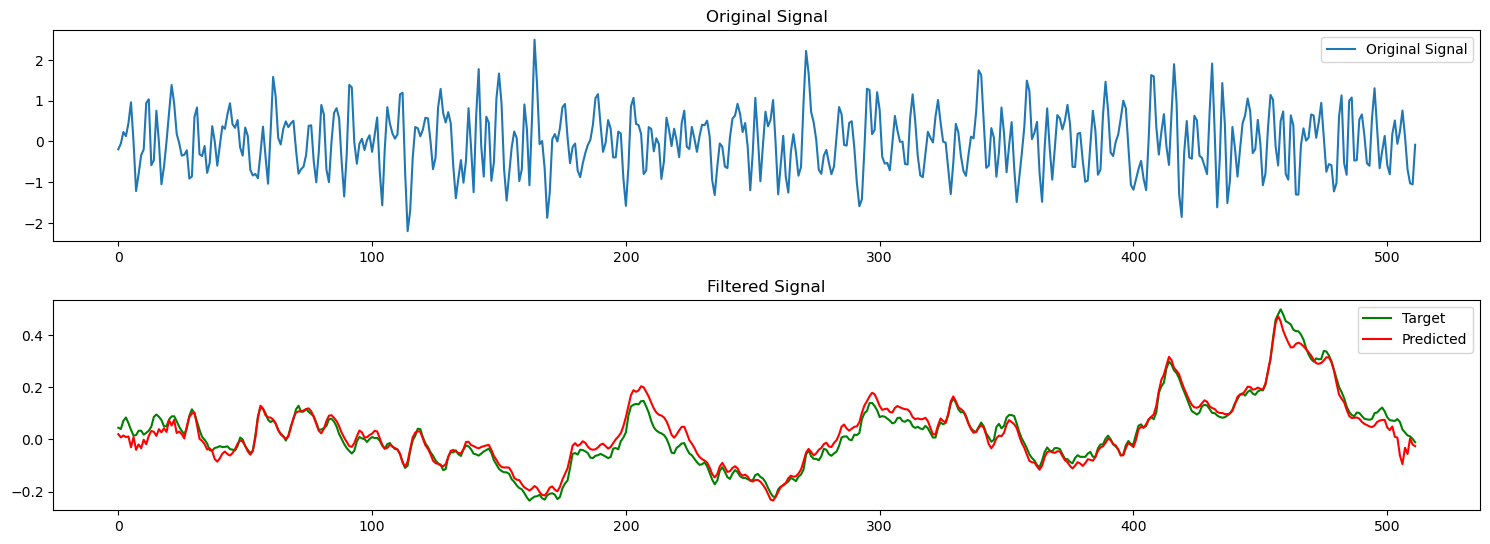

In [35]:
input_signal, target = next(iter(val_loader))

model_output = model(input_signal.to(device)).detach().cpu()

# Визуализация
i = 24
plt.figure(figsize=(15, 8))
plt.subplot(3, 1, 1)
plt.plot(range(len(input_signal[1][0])), input_signal[i][0], label='Original Signal')
plt.title('Original Signal')
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(range(len(target[1][0])), target[i][0], label='Target', color='green')
plt.title('Filtered Signal (Butterworth)')
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(range(len(model_output[1][0])), model_output[i][0], label='Predicted', color='red')
plt.title('Filtered Signal')
plt.legend()

plt.tight_layout()
plt.show()



In [33]:
def corr_coef(true_signal, predicted_signal):

    # Убираем размерность 1
    true_signal = true_signal.squeeze()
    predicted_signal = predicted_signal.squeeze()

    # Вычисляем средние значения
    mean_true = true_signal.mean()
    mean_predicted = predicted_signal.mean()

    # Считаем отклонения от среднего
    deviation_true = true_signal - mean_true
    deviation_predicted = predicted_signal - mean_predicted

    # Вычисляем числитель и знаменатель формулы для корреляции
    numerator = (deviation_true * deviation_predicted).sum()
    denominator = torch.sqrt((deviation_true ** 2).sum() * (deviation_predicted ** 2).sum())

    # Вычисляем коэффициент корреляции
    correlation = numerator / denominator
    return correlation

max_corr = 0
for i in range(64):
    corr = corr_coef(target[i], model_output[i])
    if corr > max_corr:
        max_corr = corr
        best_i = i

max_corr, best_i


(tensor(0.9771), 4)

Нейронная сеть с одним большим фильтром

In [45]:
torch.manual_seed(42)
np.random.seed(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Параметры
Fs = 512
T = 1000 
N_EMG = 8
N_joints = 1

# Временной вектор
t = np.linspace(0, T, int(Fs * T))

# Функция для создания фильтра
def butter_filter(order, cutoff, btype, fs):
    nyquist = fs / 2
    normalized_cutoff = np.array(cutoff) / nyquist
    b, a = butter(order, normalized_cutoff, btype=btype)
    return b, a

# Генерация сырых данных ЭМГ
b_myo, a_myo = butter_filter(order=5, cutoff=[15, 150], btype='band', fs=Fs)
b_vel, a_vel = butter_filter(order=1, cutoff=2, btype='low', fs=Fs)
b_hp, a_hp = butter_filter(order=3, cutoff=0.1, btype='high', fs=Fs)

s = lfilter(b_myo, a_myo, np.random.randn(N_EMG, len(t)))

input_signal = torch.tensor(s.copy())
# Создание пространственной матрицы смешивания
A = np.random.randn(N_joints, N_EMG)
target_signal = torch.abs(torch.matmul(torch.tensor(A.copy()), input_signal))
target_signal = torch.tensor(lfilter(b_vel, a_vel, target_signal, axis=1))
target_signal = torch.tensor(lfilter(b_hp, a_hp, target_signal, axis=1))

# Разделение данных на обучающую и валидационную выборки
train_ratio = 0.8
train_size = int(input_signal.shape[1] * train_ratio)
val_size = input_signal.shape[1] - train_size

train_input = input_signal[:, :train_size]
train_target = target_signal[:, :train_size]
val_input = input_signal[:, train_size:]
val_target = target_signal[:, train_size:]

train_input.shape, train_target.shape, val_input.shape, val_target.shape   

# Разбиение на окна
window_size = 2048

def create_windows(signal, target, window_size):
    x, y = [], []
    for i in range(0, signal.shape[1] - window_size + 1, window_size):
        x.append(signal[:, i:i+window_size])
        y.append(target[:, i:i+window_size])
    return torch.stack(x), torch.stack(y)

train_x, train_y = create_windows(train_input, train_target, window_size)
val_x, val_y = create_windows(val_input, val_target, window_size)

train_x.shape, train_y.shape, val_x.shape, val_y.shape  

class EMGDataset(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __len__(self):
        return self.x.shape[0]

    def __getitem__(self, idx):
        return self.x[idx].to(torch.float32), self.y[idx].to(torch.float32)

train_dataset = EMGDataset(train_x, train_y)
val_dataset = EMGDataset(val_x, val_y)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)


class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, downsample=None):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size, stride=stride, 
                               padding=(kernel_size - 1) // 2, bias=False)
        self.bn1 = nn.BatchNorm1d(out_channels)
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size, stride=1,
                               padding=(kernel_size - 1) // 2, bias=False)
        self.bn2 = nn.BatchNorm1d(out_channels)
        self.downsample = downsample

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity

        return out

class SimpleNN(nn.Module):
    def __init__(self, kernel_size=3, num_blocks=25, block_expansion=1):
        super(SimpleNN, self).__init__()

        self.weight = nn.Parameter(torch.randn(N_joints, N_EMG), requires_grad=True)

        self.conv1 = nn.Conv1d(1, block_expansion, kernel_size, padding=(kernel_size - 1) // 2, bias=False)
        self.bn1 = nn.BatchNorm1d(block_expansion)

        # Создаем и объединяем остаточные блоки
        self.res_layers = self._make_layer(ResidualBlock, block_expansion, num_blocks, kernel_size)

        self.conv = nn.Conv1d(block_expansion, 1, kernel_size, padding=1, bias=False)
        self.bn = nn.BatchNorm1d(1)

    def _make_layer(self, block, out_channels, num_blocks, kernel_size):
        layers = []
        in_channels = out_channels
        for _ in range(num_blocks):
            layers.append(block(in_channels, out_channels, kernel_size))
        return nn.Sequential(*layers)

    def forward(self, x):
        # x.shape: [batch_size(64), N_EMG(8), window_size(256)]
        x = torch.abs(torch.matmul(self.weight, x))

        x = self.conv1(x)
        x = self.bn1(x)

        # x = self.res_layers(x)

        # x = self.conv(x)
        # x = self.bn(x)

        return x
    
# Гиперпараметры
epochs = 2_000
learning_rate = 0.001

model = SimpleNN(kernel_size=101).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.9)
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=100, verbose=True, min_lr=1e-6)

def train():
    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        for inputs, targets in train_loader:
            inputs = inputs.to(device)
            targets = targets.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        train_loss /= len(train_loader)

        # Валидация
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs = inputs.to(device)
                targets = targets.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, targets)
                val_loss += loss.item()

        val_loss /= len(val_loader)

        # Обновление шедулера
        scheduler.step()
        # scheduler.step(val_loss)

        # Логирование
        if epoch % 100 == 0:
            current_lr = scheduler.get_last_lr()[0]
            # current_lr = optimizer.param_groups[0]['lr']
            print(f"Epoch {epoch}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, LR: {current_lr:.6f}")

train()


Epoch 0/2000, Train Loss: 1.0194, Val Loss: 0.7285, LR: 0.001000
Epoch 100/2000, Train Loss: 0.3727, Val Loss: 0.3713, LR: 0.000900
Epoch 200/2000, Train Loss: 0.1196, Val Loss: 0.1221, LR: 0.000810
Epoch 300/2000, Train Loss: 0.0390, Val Loss: 0.0399, LR: 0.000729
Epoch 400/2000, Train Loss: 0.0163, Val Loss: 0.0161, LR: 0.000656
Epoch 500/2000, Train Loss: 0.0105, Val Loss: 0.0101, LR: 0.000590
Epoch 600/2000, Train Loss: 0.0094, Val Loss: 0.0085, LR: 0.000531
Epoch 700/2000, Train Loss: 0.0083, Val Loss: 0.0078, LR: 0.000478
Epoch 800/2000, Train Loss: 0.0080, Val Loss: 0.0074, LR: 0.000430
Epoch 900/2000, Train Loss: 0.0081, Val Loss: 0.0071, LR: 0.000387
Epoch 1000/2000, Train Loss: 0.0078, Val Loss: 0.0070, LR: 0.000349
Epoch 1100/2000, Train Loss: 0.0076, Val Loss: 0.0069, LR: 0.000314
Epoch 1200/2000, Train Loss: 0.0076, Val Loss: 0.0068, LR: 0.000282
Epoch 1300/2000, Train Loss: 0.0073, Val Loss: 0.0068, LR: 0.000254
Epoch 1400/2000, Train Loss: 0.0076, Val Loss: 0.0068, LR: 0

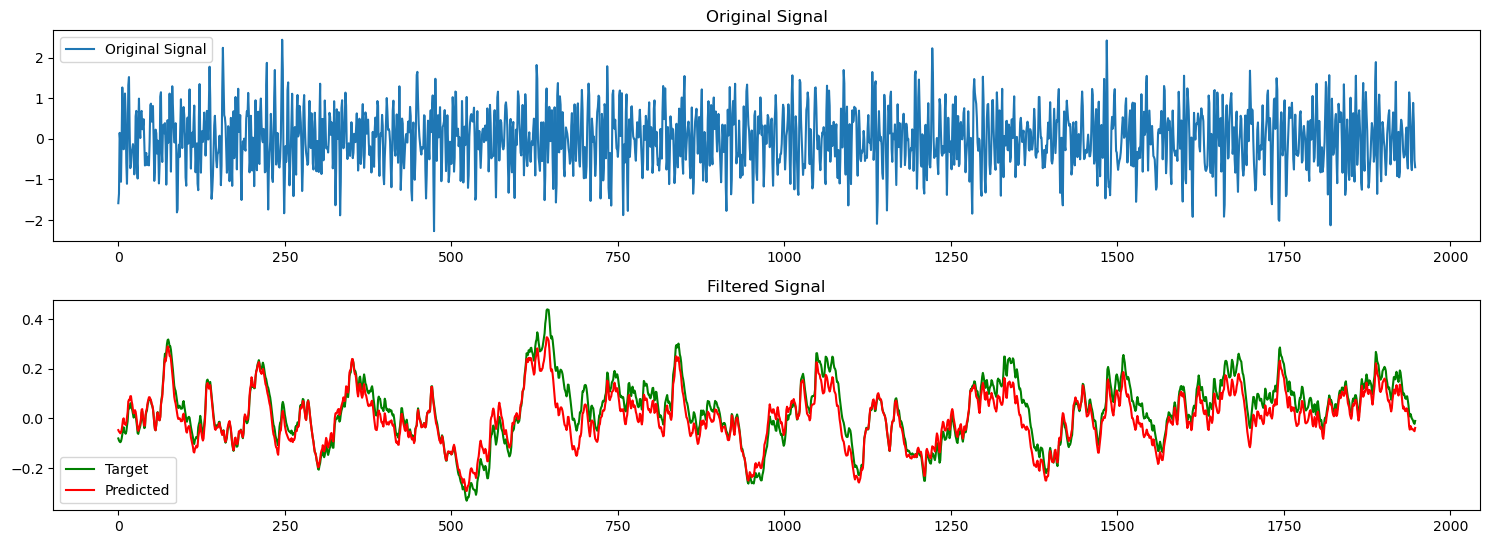

In [49]:
input_signal, target = next(iter(val_loader))

model_output = model(input_signal.to(device)).detach().cpu()

# Визуализация
i = 28
plt.figure(figsize=(15, 8))
plt.subplot(3, 1, 1)
plt.plot(range(len(input_signal[1][0][50:-50])), input_signal[i][0][50:-50], label='Original Signal')
plt.title('Original Signal')
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(range(len(target[1][0][50:-50])), target[i][0][50:-50], label='Target', color='green')
plt.title('Filtered Signal')
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(range(len(model_output[1][0][50:-50])), model_output[i][0][50:-50], label='Predicted', color='red')
plt.title('Filtered Signal')
plt.legend()

plt.tight_layout()
plt.show()



In [47]:
def corr_coef(true_signal, predicted_signal):

    # Убираем размерность 1
    true_signal = true_signal.squeeze()
    predicted_signal = predicted_signal.squeeze()

    # Вычисляем средние значения
    mean_true = true_signal.mean()
    mean_predicted = predicted_signal.mean()

    # Считаем отклонения от среднего
    deviation_true = true_signal - mean_true
    deviation_predicted = predicted_signal - mean_predicted

    # Вычисляем числитель и знаменатель формулы для корреляции
    numerator = (deviation_true * deviation_predicted).sum()
    denominator = torch.sqrt((deviation_true ** 2).sum() * (deviation_predicted ** 2).sum())

    # Вычисляем коэффициент корреляции
    correlation = numerator / denominator
    return correlation

max_corr = 0
max_iter = target.shape[0]
shift_border = 100
for i in range(max_iter):
    corr = corr_coef(target[i][:, shift_border:-shift_border], model_output[i][:, shift_border:-shift_border])
    if corr > max_corr:
        max_corr = corr
        best_i = i

max_corr, best_i


(tensor(0.9522), 41)

Downsampling target

In [52]:
torch.manual_seed(42)
np.random.seed(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Параметры
Fs = 512
T = 1000 
N_EMG = 8
N_joints = 1

# Временной вектор
t = np.linspace(0, T, int(Fs * T))

# Функция для создания фильтра
def butter_filter(order, cutoff, btype, fs):
    nyquist = fs / 2
    normalized_cutoff = np.array(cutoff) / nyquist
    b, a = butter(order, normalized_cutoff, btype=btype)
    return b, a

# Генерация сырых данных ЭМГ
b_myo, a_myo = butter_filter(order=5, cutoff=[15, 150], btype='band', fs=Fs)
b_vel, a_vel = butter_filter(order=1, cutoff=2, btype='low', fs=Fs)
b_hp, a_hp = butter_filter(order=3, cutoff=0.1, btype='high', fs=Fs)

s = lfilter(b_myo, a_myo, np.random.randn(N_EMG, len(t)))

input_signal = torch.tensor(s.copy())
# Создание пространственной матрицы смешивания
A = np.random.randn(N_joints, N_EMG)
target_signal = torch.abs(torch.matmul(torch.tensor(A.copy()), input_signal))
target_signal = torch.tensor(lfilter(b_vel, a_vel, target_signal, axis=1))
target_signal = torch.tensor(lfilter(b_hp, a_hp, target_signal, axis=1))

# Разделение данных на обучающую и валидационную выборки
train_ratio = 0.8
train_size = int(input_signal.shape[1] * train_ratio)
val_size = input_signal.shape[1] - train_size

train_input = input_signal[:, :train_size]
train_target = target_signal[:, :train_size]
val_input = input_signal[:, train_size:]
val_target = target_signal[:, train_size:]

train_input.shape, train_target.shape, val_input.shape, val_target.shape   

# Разбиение на окна
window_size = 512
downsample_size = 64
downsample_scale = window_size // downsample_size

def create_windows(signal, target, window_size):
    x, y = [], []
    for i in range(0, signal.shape[1] - window_size + 1, window_size):
        x.append(signal[:, i:i+window_size])
        y.append(target[:, i:i+window_size][:, ::downsample_scale])
    return torch.stack(x), torch.stack(y)

train_x, train_y = create_windows(train_input, train_target, window_size)
val_x, val_y = create_windows(val_input, val_target, window_size)

train_x.shape, train_y.shape, val_x.shape, val_y.shape  

class EMGDataset(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __len__(self):
        return self.x.shape[0]

    def __getitem__(self, idx):
        return self.x[idx].to(torch.float32), self.y[idx].to(torch.float32)

train_dataset = EMGDataset(train_x, train_y)
val_dataset = EMGDataset(val_x, val_y)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)


class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, downsample=None):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size, stride=stride, 
                               padding=(kernel_size - 1) // 2, bias=False)
        self.bn1 = nn.BatchNorm1d(out_channels)
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size, stride=1,
                               padding=(kernel_size - 1) // 2, bias=False)
        self.bn2 = nn.BatchNorm1d(out_channels)
        self.downsample = downsample

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity

        return out

class SimpleNN(nn.Module):
    def __init__(self, kernel_size=3, num_blocks=25, block_expansion=1, strides=[2, 2, 2]):
        super(SimpleNN, self).__init__()

        self.weight = nn.Parameter(torch.randn(N_joints, N_EMG), requires_grad=True)

        self.conv1 = nn.Conv1d(1, block_expansion, kernel_size, padding=1, bias=False)
        self.bn1 = nn.BatchNorm1d(block_expansion)

        # Создаем и объединяем остаточные блоки
        self.res_layers = self._make_layer(ResidualBlock, block_expansion, num_blocks, kernel_size)

        self.downsample_blocks = nn.ModuleList([nn.Conv1d(block_expansion, block_expansion, 
                                                          kernel_size=stride, stride=stride) for stride in strides])

        self.conv = nn.Conv1d(block_expansion, 1, kernel_size, padding=1, bias=False)
        self.bn = nn.BatchNorm1d(1)

    def _make_layer(self, block, out_channels, num_blocks, kernel_size):
        layers = []
        in_channels = out_channels
        for _ in range(num_blocks):
            layers.append(block(in_channels, out_channels, kernel_size))
        return nn.Sequential(*layers)

    def forward(self, x):
        # x.shape: [batch_size(64), N_EMG(8), window_size(512)]
        x = torch.abs(torch.matmul(self.weight, x))

        x = self.conv1(x)
        x = self.bn1(x)

        for down_block in self.downsample_blocks:
            x = down_block(x)

        x = self.res_layers(x)

        x = self.conv(x)
        x = self.bn(x)

        return x
    

# Гиперпараметры
epochs = 1_500
learning_rate = 0.001

model = SimpleNN().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.9)
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=100, verbose=True, min_lr=1e-6)

def train():
    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        for inputs, targets in train_loader:
            inputs = inputs.to(device)
            targets = targets.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        train_loss /= len(train_loader)

        # Валидация
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs = inputs.to(device)
                targets = targets.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, targets)
                val_loss += loss.item()

        val_loss /= len(val_loader)

        # Обновление шедулера
        scheduler.step()
        # scheduler.step(val_loss)

        # Логирование
        if epoch % 100 == 0:
            current_lr = scheduler.get_last_lr()[0]
            # current_lr = optimizer.param_groups[0]['lr']
            print(f"Epoch {epoch}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, LR: {current_lr:.6f}")

train()


Epoch 0/1500, Train Loss: 1.0111, Val Loss: 0.0248, LR: 0.001000
Epoch 100/1500, Train Loss: 0.0167, Val Loss: 0.0163, LR: 0.000900
Epoch 200/1500, Train Loss: 0.0056, Val Loss: 0.0043, LR: 0.000810
Epoch 300/1500, Train Loss: 0.0048, Val Loss: 0.0038, LR: 0.000729
Epoch 400/1500, Train Loss: 0.0046, Val Loss: 0.0038, LR: 0.000656
Epoch 500/1500, Train Loss: 0.0050, Val Loss: 0.0038, LR: 0.000590
Epoch 600/1500, Train Loss: 0.0046, Val Loss: 0.0037, LR: 0.000531
Epoch 700/1500, Train Loss: 0.0046, Val Loss: 0.0038, LR: 0.000478
Epoch 800/1500, Train Loss: 0.0046, Val Loss: 0.0038, LR: 0.000430
Epoch 900/1500, Train Loss: 0.0046, Val Loss: 0.0038, LR: 0.000387
Epoch 1000/1500, Train Loss: 0.0046, Val Loss: 0.0037, LR: 0.000349
Epoch 1100/1500, Train Loss: 0.0046, Val Loss: 0.0037, LR: 0.000314
Epoch 1200/1500, Train Loss: 0.0045, Val Loss: 0.0037, LR: 0.000282
Epoch 1300/1500, Train Loss: 0.0045, Val Loss: 0.0036, LR: 0.000254
Epoch 1400/1500, Train Loss: 0.0045, Val Loss: 0.0036, LR: 0

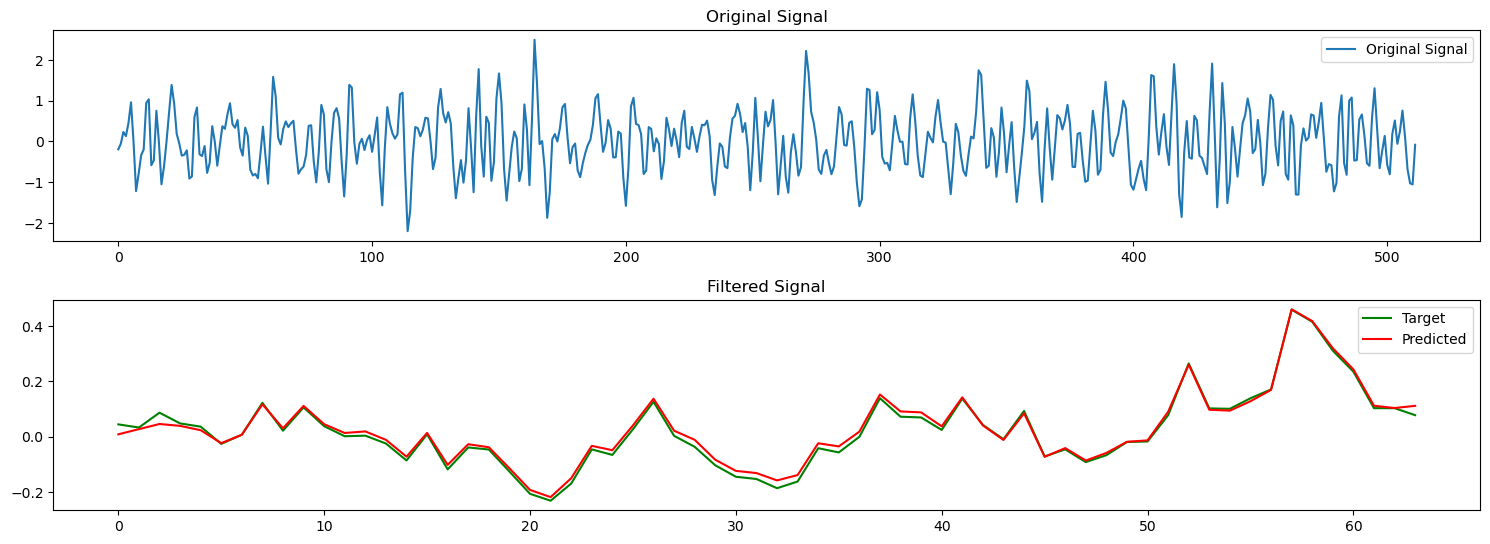

In [53]:
input_signal, target = next(iter(val_loader))

model_output = model(input_signal.to(device)).detach().cpu()

# Визуализация
i = 24
plt.figure(figsize=(15, 8))
plt.subplot(3, 1, 1)
plt.plot(range(len(input_signal[1][0])), input_signal[i][0], label='Original Signal')
plt.title('Original Signal')
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(range(len(target[1][0])), target[i][0], label='Target', color='green')
plt.title('Filtered Signal')
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(range(len(model_output[1][0])), model_output[i][0], label='Predicted', color='red')
plt.title('Filtered Signal')
plt.legend()

plt.tight_layout()
plt.show()



In [56]:
def corr_coef(true_signal, predicted_signal):

    # Убираем размерность 1
    true_signal = true_signal.squeeze()
    predicted_signal = predicted_signal.squeeze()

    # Вычисляем средние значения
    mean_true = true_signal.mean()
    mean_predicted = predicted_signal.mean()

    # Считаем отклонения от среднего
    deviation_true = true_signal - mean_true
    deviation_predicted = predicted_signal - mean_predicted

    # Вычисляем числитель и знаменатель формулы для корреляции
    numerator = (deviation_true * deviation_predicted).sum()
    denominator = torch.sqrt((deviation_true ** 2).sum() * (deviation_predicted ** 2).sum())

    # Вычисляем коэффициент корреляции
    correlation = numerator / denominator
    return correlation

max_corr = 0
max_iter = target.shape[0]
for i in range(max_iter):
    corr = corr_coef(target[i], model_output[i])
    if corr > max_corr:
        max_corr = corr
        best_i = i

max_corr, best_i


(tensor(0.9956), 24)